In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from sklearn.model_selection import train_test_split
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS

In [2]:
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)

In [3]:
# Load the data

Auto = load_data('Auto')
Auto

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
387,27.0,4,140.0,86,2790,15.6,82,1,ford mustang gl
388,44.0,4,97.0,52,2130,24.6,82,2,vw pickup
389,32.0,4,135.0,84,2295,11.6,82,1,dodge rampage
390,28.0,4,120.0,79,2625,18.6,82,1,ford ranger


In [4]:
# We can also impute the missing values of "horsepower" as we did previously

Auto['horsepower'].replace('?','104',inplace=True)
Auto['horsepower'] = pd.to_numeric(Auto['horsepower'])

In [5]:
# We will use the numeric variables in the data to predict mpg

X = Auto[['cylinders','displacement','horsepower','weight','acceleration','year','origin']]
y = Auto['mpg']

In [6]:
# Create train and test split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=314,
                                                    test_size=0.25,
                                                    shuffle=True) 
Train = pd.merge_ordered(X_train,y_train,left_on=X_train.index,right_on=y_train.index).drop(columns=['key_0'])
Test = pd.merge_ordered(X_test,y_test,left_on=X_test.index,right_on=y_test.index).drop(columns=['key_0'])

X_train

,cylinders,displacement,horsepower,weight,acceleration,year,origin
28,8,304.0,193,4732,18.5,70,1
131,6,250.0,100,3781,17.0,74,1
58,4,97.0,54,2254,23.5,72,2
215,4,111.0,80,2155,14.8,77,1
255,6,232.0,90,3210,17.2,78,1
...,...,...,...,...,...,...,...
42,8,400.0,170,4746,12.0,71,1
342,4,97.0,67,2065,17.8,81,3
201,4,97.0,71,1825,12.2,76,2
109,4,108.0,94,2379,16.5,73,3


## A Single Regression Tree

In [11]:
reg = DTR(max_depth=4)
reg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4)

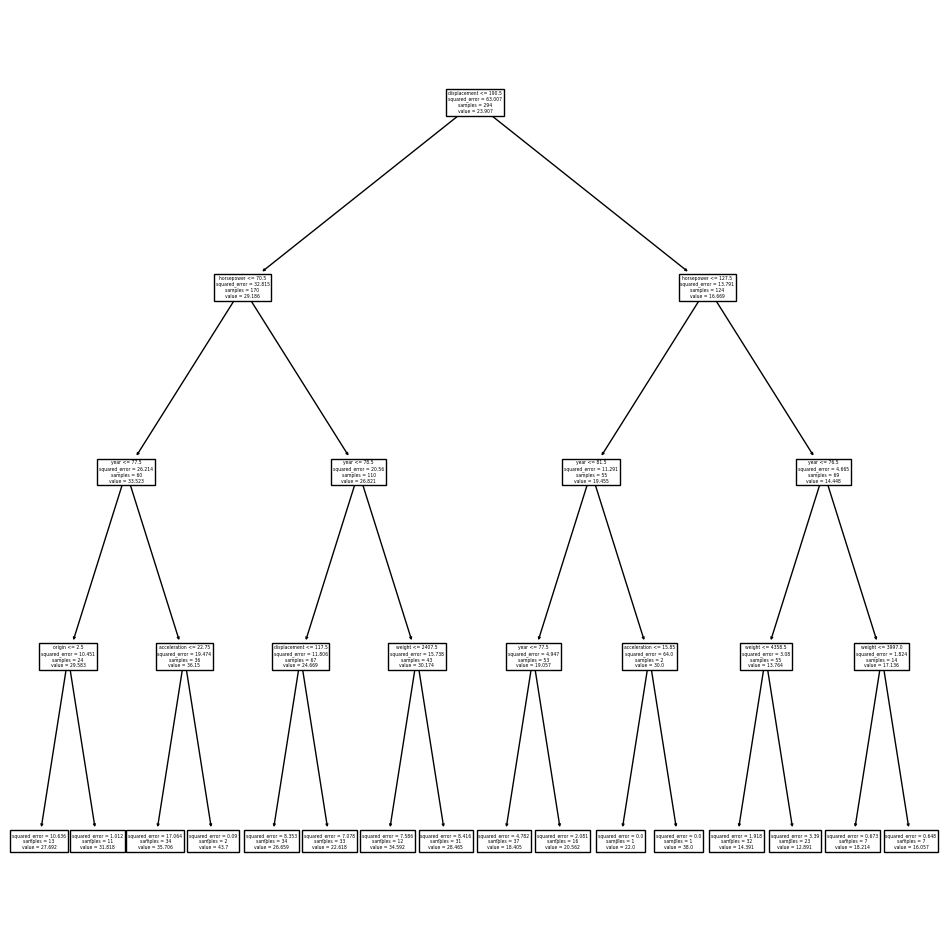

In [12]:
feature_names = list(X_train.columns)
ax = subplots(figsize=(12,12))[1]
plot_tree(reg,
          feature_names=feature_names,
          ax=ax);

## Random Forest

In [20]:
# Build the model

rf_auto = RF(max_features=7,
             n_estimators=1000,
             max_depth=10,
             random_state=314)
rf_auto.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, max_features=7, n_estimators=1000,
                      random_state=314)

In [21]:
# MSE

y_hat_rf = rf_auto.predict(X_test)
mse_rf = np.mean((y_test - y_hat_rf)**2)
print('test mse: ',mse_rf)

test mse:  4.613468490765321


In [15]:
# Feature importance list

feature_imp = pd.DataFrame(
    {'importance':rf_auto.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
displacement,0.500902
weight,0.171593
year,0.125184
horsepower,0.110496
cylinders,0.057081
acceleration,0.029402
origin,0.005343


## Gradient Boosting

In [30]:
# Build the model

gbm_auto = GBR(learning_rate=0.01,
               n_estimators=1000,
               max_depth=5,
               random_state=314)
gbm_auto.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=5, n_estimators=1000,
                          random_state=314)

In [31]:
# MSE

y_hat_gbm = gbm_auto.predict(X_test)
mse_gbm = np.mean((y_test - y_hat_gbm)**2)
print('test mse: ',mse_gbm)

test mse:  4.839240792665013


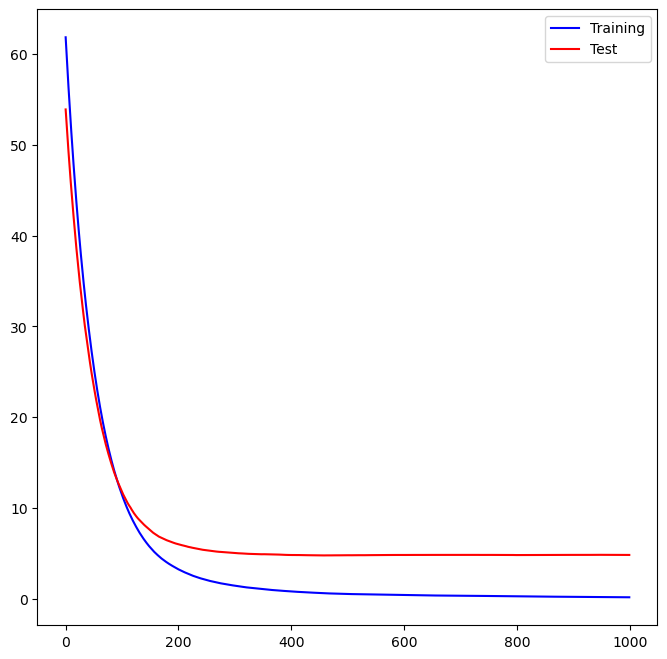

In [32]:
# We can actually plot the "progress" of a GBM

test_error = np.zeros_like(gbm_auto.train_score_)
for idx, y_ in enumerate(gbm_auto.staged_predict(X_test)):
   test_error[idx] = np.mean((y_test - y_)**2)

plot_idx = np.arange(gbm_auto.train_score_.shape[0])
ax = subplots(figsize=(8,8))[1]
ax.plot(plot_idx,
        gbm_auto.train_score_,
        'b',
        label='Training')
ax.plot(plot_idx,
        test_error,
        'r',
        label='Test')
ax.legend();

In [ ]:
# Feature importance list

feature_imp = pd.DataFrame(
    {'importance':gbm_auto.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)